# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 02 Draw spectrogram
2023/03/24
source: 

> https://hyunlee103.tistory.com/36

> https://dacon.io/en/competitions/official/235616/codeshare/1277

> https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

input file. 다른 파일을 사용하기 위해서는 이 부분을 변경하면 된다. 
- `wavfile`: file name
- `read_start`, `read_end`: 음성부분 시작과 끝. 파일마다 다르게 정의함

In [4]:
#wavfile, read_start, read_end = ('kdigits0-2.wav', 0.6, 1.1)
wavfile, read_start, read_end = ('gjang-kdigits0-3.wav', 1.0, 1.5)

### load an example windows wav file
- `librosa.load()` 로 읽는다. 다른 package 들도 사용 가능. 
- `w = wave.open()`, `scipy.io.wavfile.read()`, 등 사용가능 
- 각 함수들에 따라 $-2^{15} \sim 2^{15} -1$, $-1 \sim 1$ 의 범위가 된다.
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [5]:
# load audio file with Librosa
x, Fs = librosa.load(wavfile, sr=None, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(x,x.shape)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d' % (Fs, Ns, Nf, NFFT))

[-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04] (37952,)
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512


---
### waveform 시각화

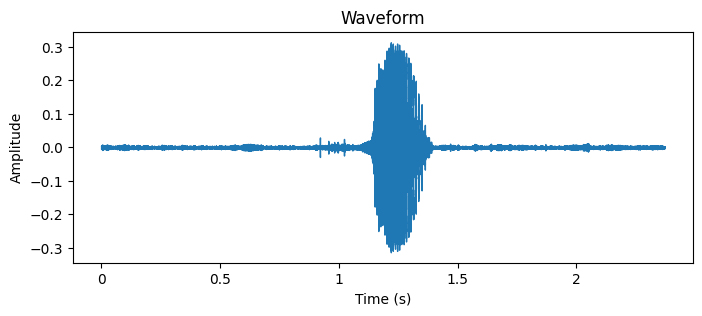

In [6]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(x, sr=Fs)
# plt.plot(x) works as well 
#plt.plot(x)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

위의 그림을 보면 작은 크기의 system 잡음(Gaussian white noise, dc noise, ac noise) 만이 존재하는 부분이 너무 많아서 음성이 아닌 음성 부분만 tight하게 잘라낸다.
- 시작값과 끝값은 위에서 정의했다 (`wavfile, read_start, read_end = ('kdigits0-3.wav', 1.0, 1.5)`)

Text(0.5, 1.0, 'Waveform')

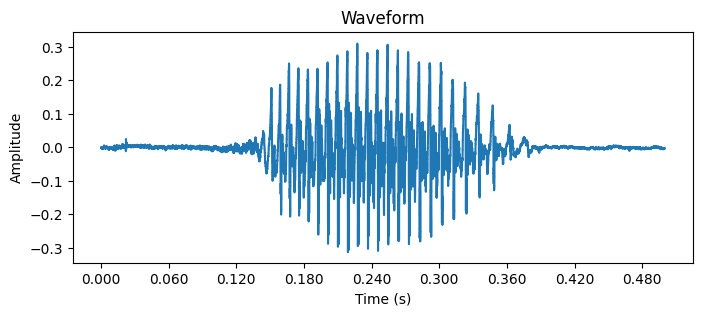

In [7]:
x, Fs = librosa.load(wavfile, sr=None, mono='True')
x = x[int(Fs*read_start):int(Fs*read_end)]

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(x, sr=Fs)
# plt.plot(x) works as well 
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

### draw spectrogram
- spectrum 은 1-D audio signal 의 시간축에서 변하는 주파수 특성을 보여주는 방법이다. 
- x축은 시간, y축은 주파수 성분을 나타내며 이를 통해 각 시각별로 주파수 성분의 변화를 볼 수 있다. 
- 기존의 package들에서는 다양한 spectrogram view 를 제공한다. 
  - `matplotlib`, `librosa`, `scipy` 등

- 먼저 `matplotlib`을 사용한 예제이다. 여러 가지 입력이 필요하지만 설명은 나중에 살펴본다.
  - `window`: analysis window
  - `NFFT`: FFT size
  - `noverlap`: shift size
  - `cmap`: color map (본 예제에서는 위에서 정의한 `pyplot.cm.bone_r`을 사용하여 강한 magnitude 는 black, 약한 값은 white 로 보여준다.

> March 26, 2023: FFT size를 Nf (320) -> NFFT (512) 로 바꿈. Spectrum 이 좀더 부드러워짐

> __참고__: `numpy.fft.fft(a, n=None)` 는 `a`의 길이가 2의 거듭제곱수가 아니면 DFT (discrete Fourier transform)을 수행한다. 효율적인 연산을 위해서는 `n`을 `a`의 길이에 가까운 2의 거듭제곱수로 넣어주는 것이 좋다.

>  __예__: `numpy.fft.fft(a, n=512)`, `a`의 길이는 320 (20ms @ $F_s = 16000$)

Text(0.5, 1.0, 'Spectrogram (dB)')

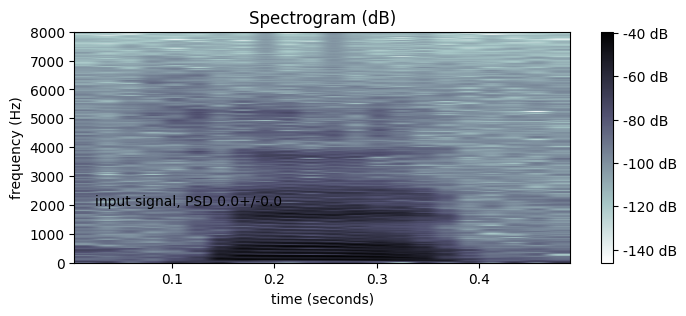

In [8]:
# draw spectrum by matplotlib
plt.figure(figsize=FIG_SIZE)
[pxx,freq,t,cax] = plt.specgram(x,Fs=Fs,
        window=np.hamming(NFFT),
        NFFT=NFFT,noverlap=Ns,
        scale_by_freq=True,
        mode='psd',scale='dB',
        cmap=cmap_plot)

lab = 'input signal, PSD %.1f+/-%.1f'%(pxx[:].mean(),pxx[:].std())
plt.text(len(x)/Fs*0.05,Fs/8,lab)
plt.xlabel('time (seconds)')
plt.ylabel('frequency (Hz)')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

- `librosa.display.specshow()` 사용

Text(0.5, 1.0, 'Spectrogram (dB)')

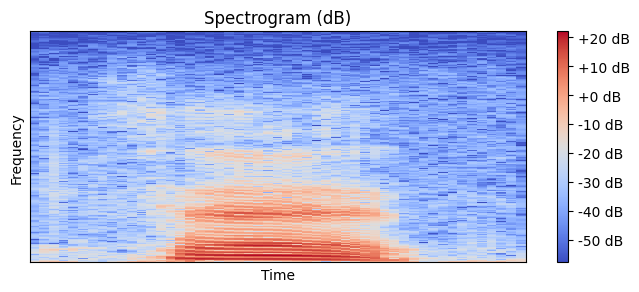

In [9]:
# draw spectrum by librosa
# https://dacon.io/en/competitions/official/235616/codeshare/1277

# STFT -> spectrogram
stft = librosa.stft(x, n_fft=NFFT, hop_length=Ns)
magnitude = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=Fs, hop_length=Ns)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

- `librosa.display.specshow()` 사용, 주파수 축을 log scale로 warping 하여 보여준다.
- 고주파 쪽의 값이 작기 때문에 저주파 영역을 자세히 볼 수 있다. 

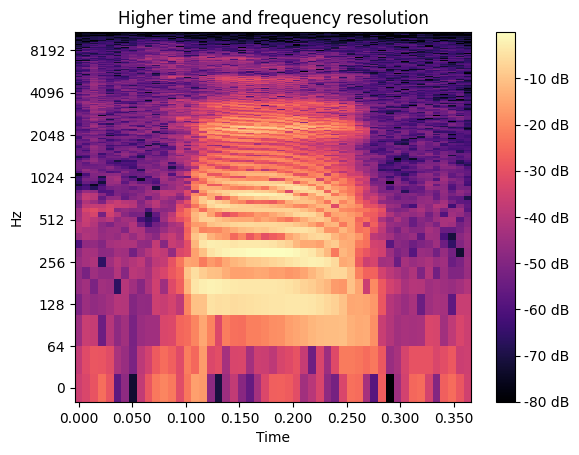

In [10]:
# draw spectrum by librosa, log scale in frequency
# https://librosa.org/doc/main/auto_examples/plot_display.html
fig, ax = plt.subplots()
D_highres = librosa.stft(x, hop_length=Ns, n_fft=NFFT)
S_db_hr = librosa.amplitude_to_db(np.abs(D_highres), ref=np.max)
img = librosa.display.specshow(S_db_hr, hop_length=Ns, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Higher time and frequency resolution')
fig.colorbar(img, ax=ax, format="%+2.f dB")

- `scipy.signal.spectrogram` 사용 예제
- 아래 예제는 $-\pi \sim \pi$ ($-{F_s}/{2} \sim {F_s}/{2}$ Hz) 을 보여주기 때문에 아래 위 대칭으로 보여진다.

(8000,) (256,) (35,) (256, 35)


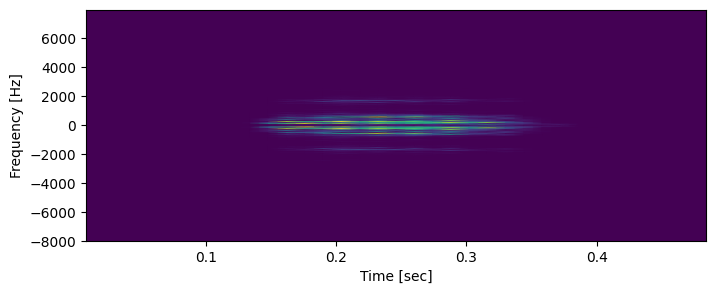

In [11]:
# draw spectrum using scipy - not working
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
f, t, Sxx = signal.spectrogram(x, Fs, return_onesided=False)
print(x.shape, f.shape, t.shape, Sxx.shape)
plt.figure(figsize=FIG_SIZE)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

- $0 \sim \pi$ ($0 \sim {F_s}/{2}$ Hz) 만 보이도록 수정함

(8000,) (256,) (35,) (256, 35)
(-8000.0, 7937.5)


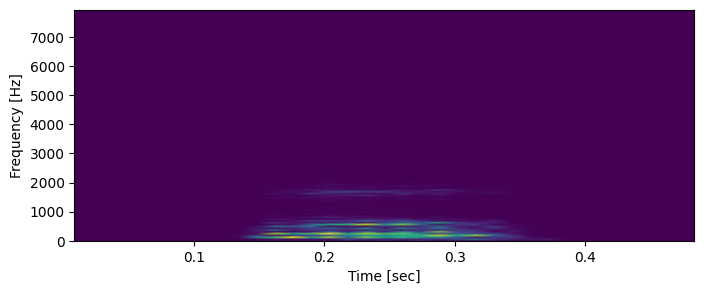

In [12]:
# draw spectrum using scipy - not working
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
f, t, Sxx = signal.spectrogram(x, Fs, return_onesided=False)
print(x.shape, f.shape, t.shape, Sxx.shape)
plt.figure(figsize=FIG_SIZE)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
ylim = plt.ylim()  # 현재 y축의 최소/최대값
print(ylim)
plt.ylim([0.0, ylim[1]])   # 0 Hz 부터
plt.show()

---
## 직접 그려본다

- 시간-주파수 관계를 이해하기 위하여 spectrogram 을 직접 그려보자. 
- 다음과 같은 과정으로 STFT (short-time Fourier transform)을 수행한다.
   1. 20 ms 간격으로 나눈다
   2. FFT 수행 
   3. `imshow`로 그린다.

1. 음성신호에 대한 Fourier 변환을 이해하기 위하여 한 frame (20ms)를 추출하여 그려본다. 

In [13]:
# 0.2~0.22 부분을 추출한다. 
y = x[int(Fs*0.2):int(Fs*0.22)]

2. FFT를 하고 실수부와 허수부를 그려본다. (note: x축은 주파수 성분 index이다. time 축 아님)

[ 1.70346069+0.00000000e+00j -0.08270431+1.40765885e+00j
  1.28466766+4.03107991e-03j  4.4506148 +7.25523380e+00j
  6.88002395-8.55507472e+00j -1.00760233+2.07525076e+00j
 -2.33778037-1.33430864e+00j 12.83486799+7.80409728e+00j
  0.68651936-1.16389591e+01j  3.11791676-8.91325459e-01j]


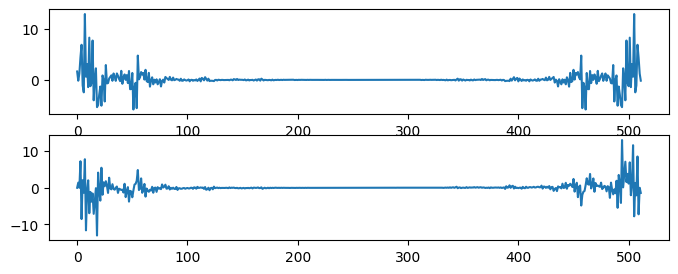

In [14]:
Y = np.fft.fft(y, n=NFFT)   # complex spectrum
print(Y[:10])
plt.figure(figsize=FIG_SIZE)
plt.subplot(2,1,1); plt.plot(Y.real)
plt.subplot(2,1,2); plt.plot(Y.imag)

- 입력이 실수일 때, 이에 대한 FFT는 실수이며
   - 실수부는 $\pi$에 대하여 symmetric (거울상으로 값이 같다.)
   - 허부부는 $\pi$에 대하여 anti-symmetric (거울상으로 부호가 반대이다.)
   - 합쳐서 쓰면 $\pi$에 대하여 complex conjugate 이다.
   $$ Y(\pi - \omega) = Y^{\ast} (\pi + \omega), \quad (a+bj)^{\ast} = a-bj $$
   - FFT 결과는 $0 \sim 2 \pi$ 범위이기 때문에 위의 그림에서 중앙을 중심으로 (anti-)symmetric 하다.

3. 음성음 phase 가 중요하지 않기 때문에 다음과 같이 절대값으로 그린다.

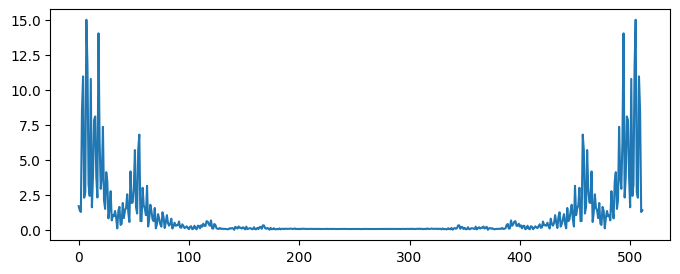

In [15]:
Y = np.abs(np.fft.fft(y, n=NFFT))
plt.figure(figsize=FIG_SIZE)
plt.plot(Y)

- complex conjugate 관계에 있는 complex number는 magnitude ($\sqrt{a^2 + b^2}$) 가 같기 때문에 $\pi$에 대하여 대칭이다. 
- 따라서 $0 \sim \pi$ 까지만 그리면 된다. 
- x축의 integer index $k$ 는 각각 $\omega = \frac{k}{N_{FFT}} \cdot 2 \pi$ 이다. 
  $N_{FFT} = 320$ 에서 $k$ 에 mapping 되는 주파수는 다음과 같다.
  $$k = \{0, 1, \ldots , 159, \quad 160, \quad 161, \ldots, 319\}$$
  $$\omega = \{ 0, \frac{1}{160} \pi, \ldots, (1-\frac{1}{160}) \pi, \quad \pi, \quad (1+\frac{1}{160}) \pi , \ldots, (2-\frac{1}{160}) \pi\}$$
- 따라서 $0 \sim \pi$ 값을 가져오기 위해서는 $k = 0 \sim 160$ (161개) 의 index가 필요하다.

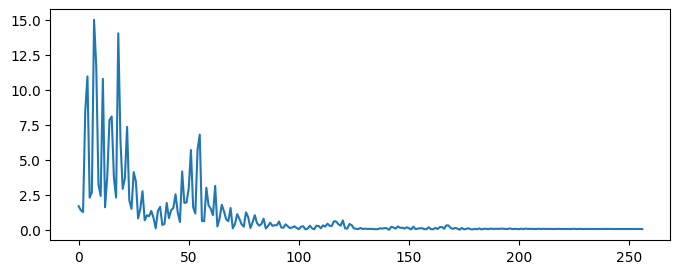

In [16]:
# 0~PI+1 까지의 절대값
Y = np.abs(np.fft.fft(y, n=NFFT))
Y = Y[:(len(Y)//2+1)]
plt.figure(figsize=FIG_SIZE)
plt.plot(Y)

- 크기 차이가 많아서 log scale 로 바꾼다.

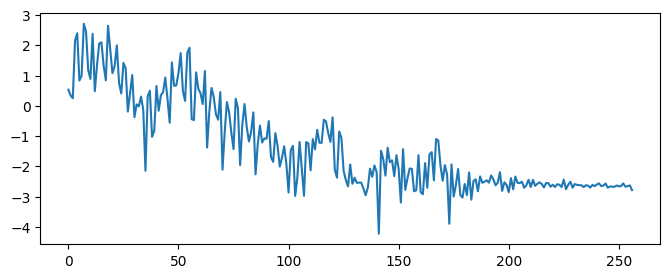

In [17]:
# 0~PI+1 까지의 절대값
# log scale 로
Y = np.log(np.abs(np.fft.fft(y, n=NFFT)))
Y = Y[:(len(Y)//2+1)]
plt.figure(figsize=FIG_SIZE)
plt.plot(Y)

- x축을 $0 \sim F_s / 2$ 로 표시한다.
- 이 방법을 이용하여 short-time Fourier transform 을 수행하고 spectrogram 을 그린다.

Text(0, 0.5, 'log magnitude')

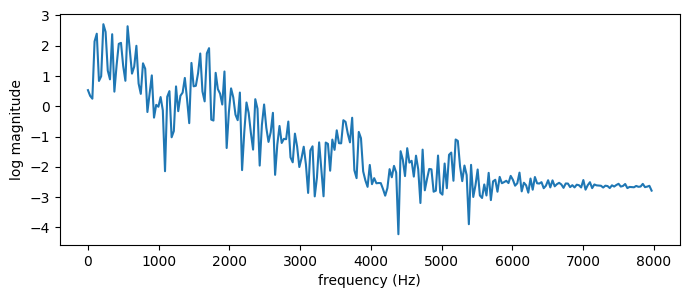

In [18]:
# 0~PI+1 까지의 절대값
# log scale 로
Y = np.log(np.abs(np.fft.fft(y, n=NFFT)))
Y = Y[:(len(Y)//2+1)]
xticks=np.arange(len(Y))/len(Y)*Fs/2
plt.figure(figsize=FIG_SIZE)
plt.plot(xticks, Y)
plt.xlabel('frequency (Hz)')
plt.ylabel('log magnitude')

---
### Short-time Fourier transform

- 음성신호를 10ms~20ms 의 짧은 구간에서는 stable 하다고 가정하고(quasi-stationary) Fourier transform 을 적용한다.

__(그림) STFT rectagular window__

- 각각의 cross-sectional figure를 붙여서 spectrogram 을 그린다.
- 먼저 Fourier 변환 값이 0일 때 $\log 0 \rightarrow -\infty$ 오류를 막기 위해 다음의 함수를 사용한다.

In [19]:
# log function to prevent 0 input
def log_safe(x, epsilon=1e-10):
    return np.log(np.maximum(x,epsilon))

- 전체 음성신호를 20ms 구간으로 잘게 나눈다.
- 마지막에 20ms 되지 않는 짜투리(leftover)는 어떻게 해결하는가?
  - zero padding 을 하고 Fourier transform (음성 통신 등에서 필요)
  - 버린다 (아래 코드)
$$ T = |x| \quad K = \lfloor T/N_f \rfloor \quad \mathbf{y}[k] = x[(k-1) N_f + 1 \ldots k N_f ]$$
$$ \mathbf{X} \in \mathcal{R}^{ \left( \lfloor Nf/2 \rfloor + 1 \right) \times K} $$
$$ X(\omega, k) = \log \left| FFT( \mathbf{y}[k] )(\omega) \right| \quad \omega \in \{ 1, 2, \ldots , \left( \lfloor Nf/2 \rfloor + 1 \right) \} $$

In [20]:
# Short-time Fourier transform
# 20ms 간격으로 나눈다
T = len(x)   # number of samples
num_frames = T//Nf# 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
#hNo = Nf//2+1
hNo = NFFT//2+1
X = np.zeros((hNo,num_frames))
for i in range(num_frames):
    y = np.fft.fft(x[(i*Nf):((i+1)*Nf)], n=NFFT)
    X[:,i] = log_safe(np.abs(y[:hNo]))
print(X.shape)

(257, 25)


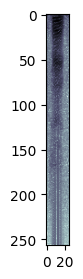

In [21]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(X, cmap=cmap_plot)

- image 를 그리는 `imshow` 함수를 사용한다.
- x축은 25, y축은 161개이기 때문에 매우 좁은 사각형으로 표시된다. 
- 어차피 시간과 주파수 축은 의미가 다르기 때문에 같은 스케일로 그릴 필요가 없으므로 다음과 같이 수정한다.

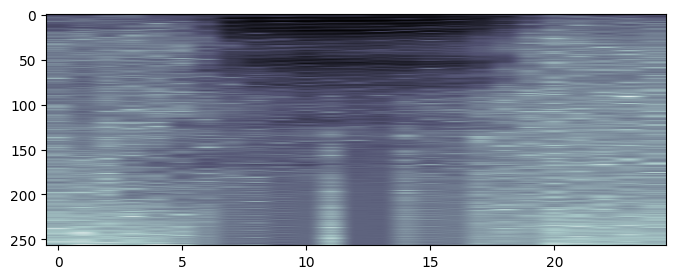

In [22]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(X, cmap=cmap_plot, aspect='auto')

- `imshow`의 기본 설정은 원점 `(0, 0)`이 왼쪽 위에서 시작한다. 
- 저주파를 아래쪽에 표시한다. 

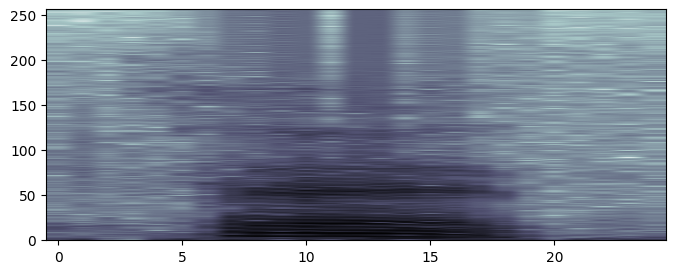

In [23]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower')

- x축과 y축의 범위와 이름을 적어준다

Text(0, 0.5, 'frequency (Hz)')

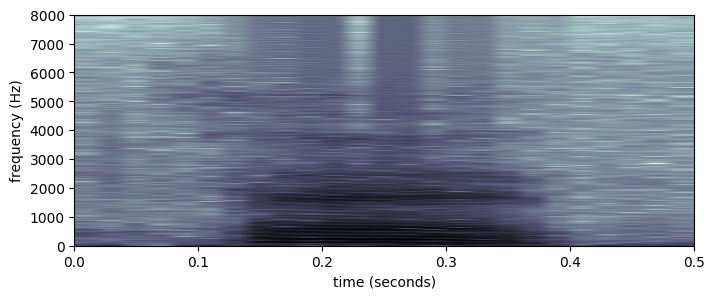

In [24]:
specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
plt.figure(figsize=FIG_SIZE)
plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis)
plt.xlabel('time (seconds)')
plt.ylabel('frequency (Hz)')

- 함수 `imshow`는 minimum ~ maximum 을 균등하게 나눈다. 예를 들어 8 bits gray scale 에서는 0 ~ 255 
- 음성의 크기가 큰 부분만 눈에 잘 띄도록 그려주기 위하여 상위 80~90% 만 그려준다. 
   1. $X(\omega, k) < \theta \Rightarrow X(\omega, k) \leftarrow \theta $, 또는 
   2. `imshow` 의 `vmin`, `vmax` 이용

2.709465464504662 -1.820827773214959


Text(0, 0.5, 'frequency (Hz)')

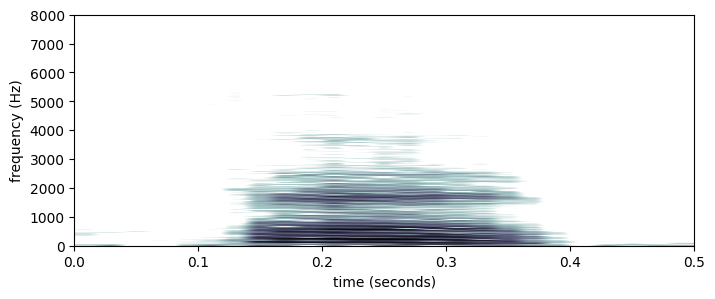

In [25]:
# 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
vmax = np.max(X[:])
vmin = np.percentile(X[:], 80)
print(vmax, vmin)

specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
plt.figure(figsize=FIG_SIZE)
plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
plt.xlabel('time (seconds)')
plt.ylabel('frequency (Hz)')

- 나중에 사용하기 위하여 함수로 만든다.
- `islogscale`, `isdraw` 인자를 이용하여 log scale 로 그릴지, 그림을 그리지 않고 spectrum 만 구할 수도 있다.

---
### Hamming windows

__(그림) rectangular and hamming window 비교__

- dB scale로 그리기위해 `log_safe()` 함수를 변형하여 `decibel_safe()` 함수를 정의한다.
- $\textrm{dB} = 20 \log_{10} |x[n]| = 10 \log_{10} x^2$ for real input, 
  $\textrm{dB} = 20 \log_{10} |X(\omega)| = 10 \log_{10} X(\omega) X^{\ast}(\omega)$ for complex input. 
  - ($|\cdot| = \sqrt{{\cdot}^2}$)
- 다양하게 사용하기 위해(for better generalization) 입력은 complex로 가정한다.
  returns $ 10 \log_{10} x x^{\ast} $

In [26]:
# returns decibel, with preventing 0 input
# note: input should be X(w) or x[n]
# dB = 20 log_10 (abs(x)) = 10 log_10 ( x^2 ) 
def decibel_sq_safe(x, epsilon=1e-10):
    return 10*np.log10(np.maximum(np.real(x*np.conj(x)),epsilon))

- Hamming window 와 rectangular window 의 time domain, Fourier transform 의 실수 성분, 그리고 절대값을 직접 그려 본다.
- 128-point window
- 보다 차이를 잘 보여주기 위해서 앞 뒤에 128 samples 의 0 을 padding 한다 
- signal 길이 $3 \times 128$, FFT size $4 \times 128$

Text(0.5, 1.0, 'hamming, |Y| in dB')

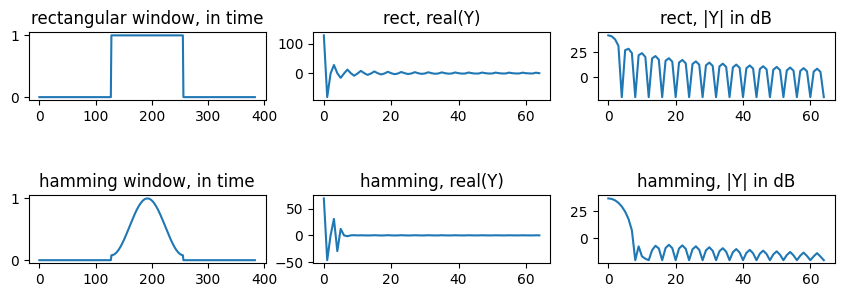

In [27]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,1]))
T = 128

# rectangular window
win = np.zeros(T*3)
win[T:(2*T)] = np.ones(T)
plt.subplot(3,3,1)
plt.plot(win)
plt.title('rectangular window, in time')
y = np.fft.fft(win, n=T*4)[0:(T//2+1)]
plt.subplot(3,3,2)
plt.plot(y.real)
plt.title('rect, real(Y)')
plt.subplot(3,3,3)
plt.plot(decibel_sq_safe(y,epsilon=1e-2))
plt.title('rect, |Y| in dB')

win = np.zeros(T*3)
win[T:(2*T)] = librosa.filters.get_window('hamming', T, fftbins=True)
plt.subplot(3,3,7)
plt.plot(win)
plt.title('hamming window, in time')
y = np.fft.fft(win, n=T*4)[0:(T//2+1)]
plt.subplot(3,3,8)
plt.plot(y.real)
plt.title('hamming, real(Y)')
plt.subplot(3,3,9)
plt.plot(decibel_sq_safe(y,epsilon=1e-2))
plt.title('hamming, |Y| in dB')

- decibel 영역에서 보면 rectagular window는 주파수 영역에서 side lobe 의 크기가 hamming window에 비해 상대적으로 크다. 
   - hamming window 는 side 의 크기가 40 dB 이상 작다. rectagular window는 5-10 dB drop
- 다만 hamming window 의 main lobe 의 폭이 크다(smoothing 효과)
- short time Fourier analysis 에서 window 의 주파수 특성이 convolution 된다. 이를 확인하기 위하여 다음과 같은 pure sinusoid 에 대하여 windowing 의 효과를 확인한다.
- 아래와 같이 rectangular window 가 적용된 sinusoid 를 적당히 생성한다. 

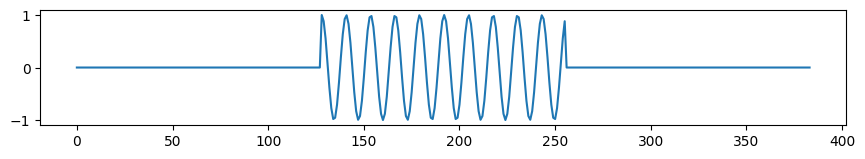

In [28]:
T = 128
sinusoid = np.zeros(3*T)
sinusoid[T:(2*T)] = np.cos(np.arange(T)/T*20*np.pi)
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.5]))
plt.plot(sinusoid)

- spectrum 을 dB scale 로 그려본다. 

Text(0, 0.5, 'dB')

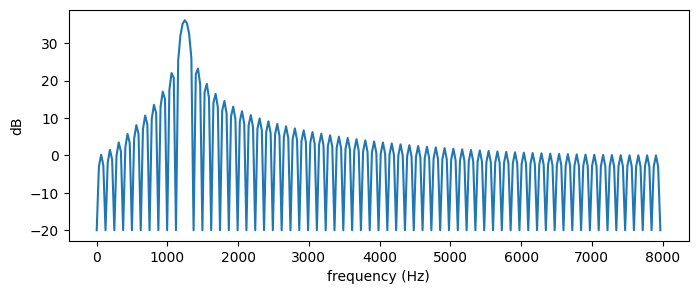

In [29]:
# 0~PI+1 까지의 절대값
# log scale 로
y = np.fft.fft(sinusoid, n=T*4)
y = y[:(len(y)//2+1)]
y = decibel_sq_safe(y,epsilon=1e-2)
xticks=np.arange(len(y))/len(y)*Fs/2
plt.figure(figsize=FIG_SIZE)
plt.plot(xticks, y)
plt.xlabel('frequency (Hz)')
plt.ylabel('dB')

- hamming window에 대하여 반복한다. 

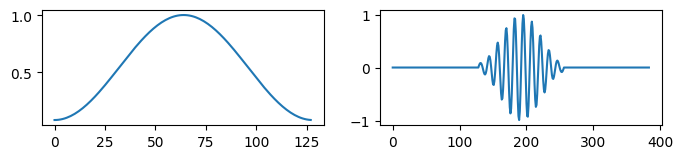

In [30]:
T = 128

sinusoid = np.zeros(3*T)
sinusoid[T:(2*T)] = np.sin(np.arange(T)/T*20*np.pi)

win = librosa.filters.get_window('hamming', T, fftbins=True)
sinusoid[T:(2*T)] = win*sinusoid[T:(2*T)] 

plt.figure(figsize=FIG_SIZE*np.array([1,0.5]))
plt.subplot(1,2,1)
plt.plot(win)
plt.subplot(1,2,2)
plt.plot(sinusoid)

- spectrum 을 dB scale 로 그려본다. side lobe의 크기는 40 dB 이상 차이가 난다.

Text(0, 0.5, 'dB')

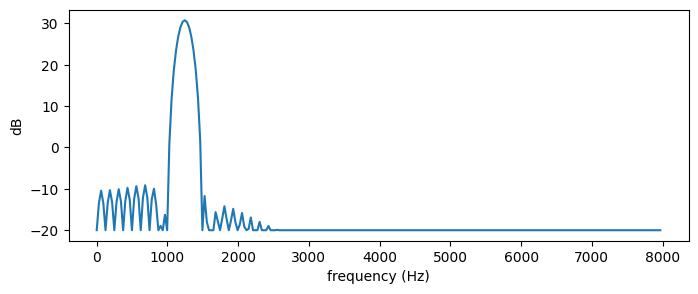

In [31]:
# 0~PI+1 까지의 절대값
# decibel scale 로
y = np.fft.fft(sinusoid, n=T*4)
y = y[:(len(y)//2+1)]
y = decibel_sq_safe(y,epsilon=1e-2)
xticks=np.arange(len(y))/len(y)*Fs/2
plt.figure(figsize=FIG_SIZE)
plt.plot(xticks, y)
plt.xlabel('frequency (Hz)')
plt.ylabel('dB')

---
### STFT에 hamming window 적용 

- hamming window를 short time Fourier transform 을 적용한다. 

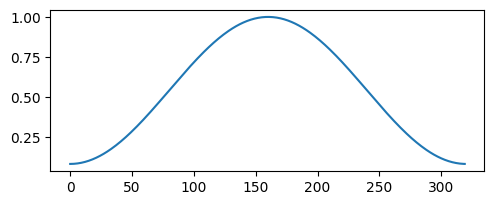

In [32]:
win = librosa.filters.get_window('hamming', Nf, fftbins=True)
plt.figure(figsize=FIG_SIZE*np.array([0.7,0.7]))
plt.plot(win)

__(그림) NFFT Nf Ns hamming window 곱하는 영역 보여주기__

- __(그림) hamming window, half overlap__

- 20 ms frame size, 10 ms shift size 적용, hamming window
- 다음과 같이 함수 `drawspectrogram2()`를 일반적으로 사용할 수 있도록 정의한다.
  - frame size, shift size 를 

In [33]:
def drawspectrogram2(x, Nf, Ns=None, winname='hamming', minpercentile=80, isdbscale=True, isdraw=True):
    # Short-time Fourier transform with half-overlap 
    # Nf: analysis size
    # Ns: shift size 
    # NFFT: FFT size, power of 2
    if Ns==None: Ns=Nf//2
    num_frames = (len(x)-Nf)//Ns+1  # 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
    hNo = NFFT//2+1
    X = np.zeros((hNo,num_frames))
    
    # generate window
    if winname=='rect' or winname=='rectangular':
        win = np.ones(Nf)
    else:   # hamming, hann, etc.
        win = librosa.filters.get_window(winname, Nf, fftbins=True)
        
    # STFT
    for i in range(num_frames):
        y = np.fft.fft(win*x[(i*Ns):(i*Ns+Nf)], n=NFFT)
        y = y[:hNo]
        if isdbscale: y = decibel_sq_safe(y)
        else: y = np.abs(y)
        X[:,i] = y

    if isdraw:
        # 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
        vmax = np.max(X[:])
        vmin = np.percentile(X[:], minpercentile)
        specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
        plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
        plt.xlabel('time (seconds)')
        plt.ylabel('frequency (Hz)')
    
    return X

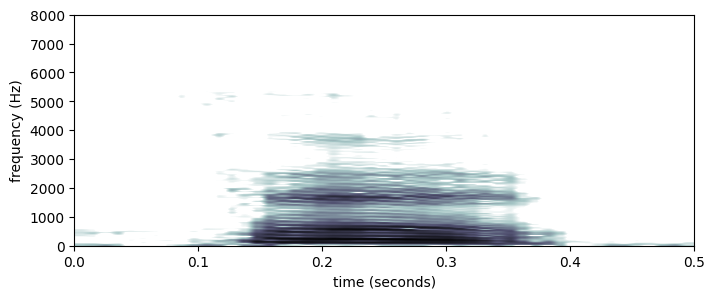

In [34]:
plt.figure(figsize=FIG_SIZE)
X = drawspectrogram2(x, Nf, Ns, 'hamming')

### 비교를 위해 같이 그리기 

Text(0.5, 1.0, 'hamming window')

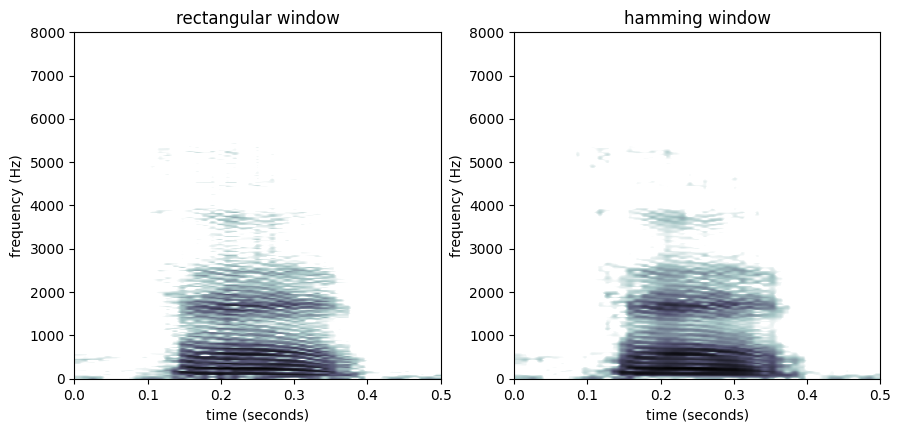

In [35]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,1.5]))
plt.subplot(1,2,1)
X = drawspectrogram2(x, Nf, Ns, 'rect')
plt.title('rectangular window')
plt.subplot(1,2,2)
X = drawspectrogram2(x, Nf, Ns, 'hamming')
plt.title('hamming window')

- 차이가 그리 잘 보이진 않지만 그래도 hamming window 를 써야 한다. 

---
## Programming assignments: Resampling

1. Complete 80% or more quantile minimum value spectrum drawing
2. Upsampling (interpolation)
   - from 16 kHz audio file, resample it to 32 kHz, 48 kHz, and 44.1 kHz
   - use your own recording (not gjang-kdigits0-3.wav given as a reference)
   - need to implement low-pass FIR filter
   - check if there is no frequency contents over 8 kHz frequency by spectrogram
   - listen to the outputs
   - save them as xxx_32k.wav, xxx_48k.wav, xxx_44k.wav
3. Decimation
   - for each of xxx_32k.wav, xxx_48k.wav, xxx_44k.wav
   - resample them to 8 kHz and 11.025 kHz
   - save them as xxx_8k.wav and xxx_11k.wav

- __Submission__
   본인의 github 에 코드와 결과를 올려 놓는다. 

- Upsampling (interpolation) 방법
    - 16 kHz --> 32 KHz
       - 중간값 등을 이용하여 중간값을 채운다.
       - cutoff frequency 8kHz 인($\frac{1}{2} \pi$) lowpass filter 적용)
    - 16 kHz --> 48 KHz
       - 한 sample 당 2개씩 추가(예를 들어 $\frac{1}{3} x[n]+\frac{2}{3} x[n+1] \quad \frac{2}{3} x[n] + \frac{1}{3} x[n+1]$)
       - cutoff frequency 8kHz 인($\frac{1}{3} \pi$) lowpass filter 적용)
    - 16 kHz --> 44.1 KHz
       - 적당히 $44.1/16$ 만큼 resampling 
       - cutoff frequency 8kHz 인($\frac{8}{22.1} \pi$) lowpass filter 적용)
       
- Decimation 방법
    - 32 kHz --> 8 KHz
       - cutoff frequency 4kHz 인($\frac{1}{4} \pi$) lowpass filter 적용)
       - pick one for every 4 samples
    - 32 kHz --> 11.025 KHz
       - cutoff frequency 5.5125 kHz 인($\frac{5.5125}{16} \pi$) lowpass filter 적용)
       - 적당히 고르거나 생성한다

Low-/High-pass filtering 
- decimation, interpolation 을 위해서는 lowpass filter가 필요한다.
- 아래의 예제를 참고한다. (안 써도 된다.)

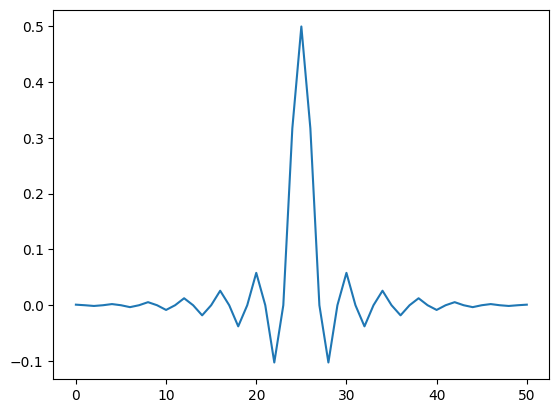

In [36]:
# scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=None)[source]
# FIR filter design using the window method.

a = signal.firwin(51, 0.5, window='hamming')
plt.plot(a)

## End of Lab 02